In [1]:
"""
Outlier detection using alibi-detect

pip install alibi-detect

https://github.com/SeldonIO/alibi-detect
Documentation: https://docs.seldon.io/_/downloads/alibi-detect/en/v0.5.1/pdf/

We will be using VAE based outlier detection. Based on this paper:
    https://arxiv.org/pdf/1312.6114.pdf

Data set info: https://openaccess.thecvf.com/content_CVPR_2019/papers/Bergmann_MVTec_AD_--_A_Comprehensive_Real-World_Dataset_for_Unsupervised_Anomaly_CVPR_2019_paper.pdf
Data set link: https://www.mvtec.com/company/research/datasets/mvtec-ad
"""


'\nOutlier detection using alibi-detect\n\npip install alibi-detect\n\nhttps://github.com/SeldonIO/alibi-detect\nDocumentation: https://docs.seldon.io/_/downloads/alibi-detect/en/v0.5.1/pdf/\n\nWe will be using VAE based outlier detection. Based on this paper:\n    https://arxiv.org/pdf/1312.6114.pdf\n\nData set info: https://openaccess.thecvf.com/content_CVPR_2019/papers/Bergmann_MVTec_AD_--_A_Comprehensive_Real-World_Dataset_for_Unsupervised_Anomaly_CVPR_2019_paper.pdf\nData set link: https://www.mvtec.com/company/research/datasets/mvtec-ad\n'

In [2]:
import os
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dense, Reshape, InputLayer, Flatten

from alibi_detect.od import OutlierAE, OutlierVAE
from alibi_detect.utils.visualize import plot_instance_score, plot_feature_outlier_image


2.9.1


In [3]:
# Read good data
image_directory = 'D:/Programming/Python/Data/carpet/train/'
SIZE = 64
dataset = []  #Many ways to handle data, you can use pandas. Here, we are using a list format.  

good_images = os.listdir(image_directory + 'good/')
for i, image_name in enumerate(good_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'good/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        dataset.append(np.array(image))

dataset = np.array(dataset)

train = dataset[0:200]
test = dataset[200:279]

train = train.astype('float32') / 255.
test = test.astype('float32') / 255.


In [4]:
image_directory = 'D:/Programming/Python/Data/carpet/test/'

bad_images = os.listdir(image_directory + 'bad/')
bad_dataset=[]
for i, image_name in enumerate(bad_images):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(image_directory + 'bad/' + image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((SIZE, SIZE))
        bad_dataset.append(np.array(image))

    
bad_dataset = np.array(bad_dataset)
bad_dataset = bad_dataset.astype('float32') / 255.


In [5]:
# Build Autoencoder model

encoding_dim = 1024  #Dimension of the bottleneck encoder vector. 
dense_dim = [8, 8, 512] #Dimension of the last conv. output. This is used to work our way back in the decoder. 

#Define encoder
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=train[0].shape),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ])

print(encoder_net.summary())
#print(encoder_net.input_shape)

#Define the decoder. 
#Start with the bottleneck dimension (encoder vector) and connect to dense layer 
#with dim = total nodes in the last conv. in the encoder. 
decoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(encoding_dim,)),
      Dense(np.prod(dense_dim)),
      Reshape(target_shape=dense_dim),
      Conv2DTranspose(256, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2DTranspose(3, 4, strides=2, padding='same', activation='sigmoid')
  ])

print(decoder_net.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 512)         1049088   
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 1024)              33555456  
                                                                 
Total params: 34,738,880
Trainable params: 34,738,880
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________

In [6]:
#Define and train the outlier detector. 

latent_dim = 1024  #(Same as encoding dim. )

# initialize outlier detector
od = OutlierVAE(threshold=.015,  # threshold for outlier score above which the element is flagged as an outlier.
                score_type='mse',  # use MSE of reconstruction error for outlier detection
                encoder_net=encoder_net,  # can also pass VAE model instead
                decoder_net=decoder_net,  # of separate encoder and decoder
                latent_dim=latent_dim,
                samples=4)

print("Current threshold value is: ", od.threshold)


Current threshold value is:  0.015


In [7]:
# train
# from alibi_detect.models.tensorflow.losses import elbo 
# evidence lower bound loss

adam = tf.keras.optimizers.Adam(lr=1e-4)

od.fit(train,
       optimizer = adam,
       epochs=20,
       batch_size=4,
       verbose=True)

print("Current threshold value is: ", od.threshold)


C:\Users\User\anaconda3\myanaconda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


50/50 [=] - 45s 892ms/step - loss_ma: -20148.5700
Current threshold value is:  0.015


The instance score is: 0.0022276489
Is this image an outlier (0 for NO and 1 for YES)? 0


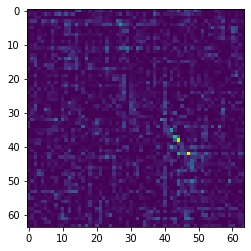

In [8]:
img_num = 9
test_bad_image = bad_dataset[img_num].reshape(1, 64, 64, 3)
plt.imshow(test_bad_image[0])

test_bad_image_recon = od.vae(test_bad_image)
test_bad_image_recon = test_bad_image_recon.numpy()
plt.imshow(test_bad_image_recon[0])

test_bad_image_predict = od.predict(test_bad_image) #Returns a dictionary of data and metadata

#Data dictionary contains the instance_score, feature_score, and whether it is an outlier or not. 
#Let u look at the values under the 'data' key in our output dictionary
bad_image_instance_score = test_bad_image_predict['data']['instance_score'][0]
print("The instance score is:", bad_image_instance_score)

bad_image_feature_score = test_bad_image_predict['data']['feature_score'][0]
plt.imshow(bad_image_feature_score[:,:,0])
print("Is this image an outlier (0 for NO and 1 for YES)?", test_bad_image_predict['data']['is_outlier'][0])


Current threshld value is:  0.002
(30, 64, 64, 3)
['instance_score', 'feature_score', 'is_outlier']


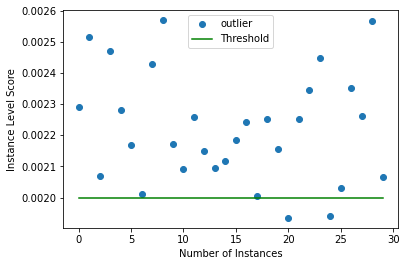

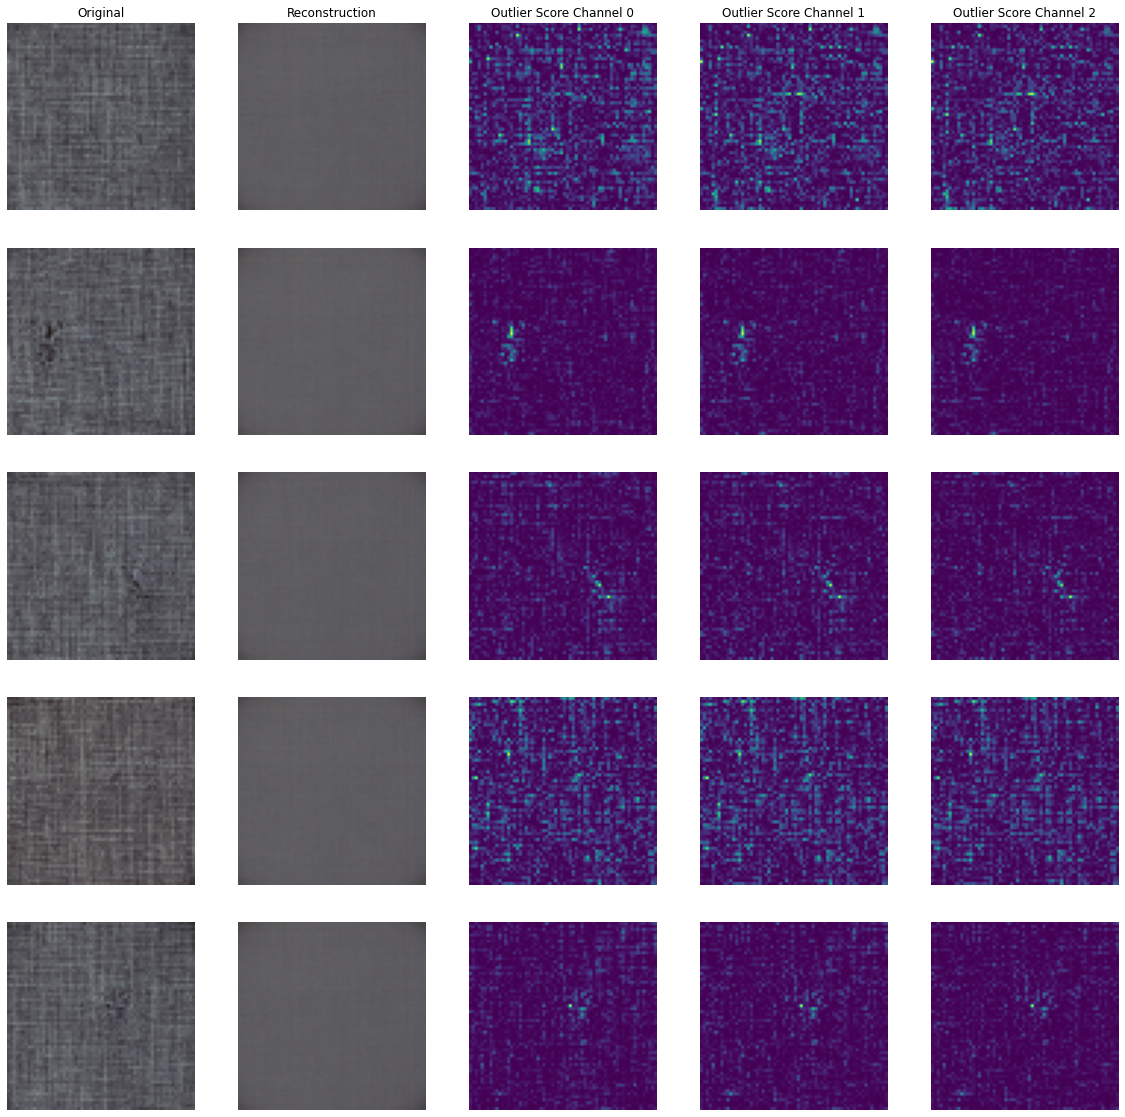

In [17]:
#You can also manually define the threshold based on your specific use case. 
od.threshold = 0.002
print("Current threshld value is: ", od.threshold)

#Let us check it for multiple images
X = bad_dataset[:30]

print(X.shape)

od_preds = od.predict(X,
                      outlier_type='instance',    # use 'feature' or 'instance' level
                      return_feature_score=True,  # scores used to determine outliers
                      return_instance_score=True)

print(list(od_preds['data'].keys()))

#Scatter plot of instance scores. using the built-in function for the scatterplot. 
target = np.ones(X.shape[0],).astype(int)  # Ground truth (all ones for bad images)
labels = ['normal', 'outlier']
plot_instance_score(od_preds, target, labels, od.threshold) #pred, target, labels, threshold

# Plot features for select images, using the built in function (plot_feature_outlier_image)
X_recon = od.vae(X).numpy()
plot_feature_outlier_image(od_preds,
                           X,
                           X_recon=X_recon,
                           instance_ids=[2,4,5,8,10],  # pass a list with indices of instances to display
                           max_instances=5,  # max nb of instances to display
                           outliers_only=False)  # only show outlier predictions


In [12]:
print(X.shape)

(30, 64, 64, 3)


In [14]:
print((od_preds['data']))

{'instance_score': array([0.00226917, 0.00263739, 0.00209799, 0.0024463 , 0.0022537 ,
       0.0022035 , 0.00204778, 0.00249947, 0.00248515, 0.00220747,
       0.00216254, 0.00224837, 0.00219112, 0.00206586, 0.00214457,
       0.00213712, 0.00224307, 0.00200154, 0.00226143, 0.00210016,
       0.00194007, 0.00224635, 0.00240753, 0.00245698, 0.00194512,
       0.00205804, 0.00226403, 0.00217811, 0.00253581, 0.00207243],
      dtype=float32), 'feature_score': array([[[[3.92236601e-04, 9.57295852e-05, 2.31612707e-04],
         [1.49891348e-04, 3.77185461e-05, 1.72130349e-05],
         [6.89901499e-05, 1.98095076e-05, 9.01310796e-06],
         ...,
         [2.15989561e-03, 1.83944905e-03, 9.97598167e-04],
         [3.15681973e-04, 1.52001099e-04, 4.30142863e-05],
         [3.00710928e-03, 3.70691391e-03, 2.17405614e-03]],

        [[5.58213622e-04, 2.55554391e-04, 5.60462322e-05],
         [9.75263189e-04, 8.96989019e-04, 2.95540667e-04],
         [1.27749357e-04, 8.30942954e-05, 4.4563148